### Notebook information

This notebook focuses on data loading, cleaning, and basic preprocessing using Python (Pandas). 

The data originates from a real industrial test environment at SmartFactoryOWL (Fraunhofer IOSB-INA).
It represents binary signals from sensors and actuators within a storage module, which is part of a modular and automated production system.
These signals reflect the operation of components such as a funnel, silo, aspirator, and pneumatic actuators.

### 1. Load Libraries 

In [2]:
import pandas as pd 
from IPython.display import display
import os 
import joblib


import matplotlib.pyplot as plt
import seaborn as sns   

from sklearn.ensemble import IsolationForest

In [3]:
os.listdir('../01_RawData')

['Deliverymodule.csv',
 'Dosingmodule.csv',
 'Filling_ALL.module.csv',
 'Filling_CapGrabber.module.csv',
 'Filling_CapScrewer.module.csv',
 'Filling_CornPortioning.module.csv',
 'Filling_Pump.module.csv',
 'Production.csv',
 'Storagemodule.csv']

In [4]:
path_storagemodele = '../01_RawData/Storagemodule.csv'
df_storage = pd.read_csv(path_storagemodele, sep=',')


#### 2. Column Descriptions 

The dataset consists of binary sensor and actuator signals captured from a storage module in a manufacturing system.  
Below is a brief description of each column:

- `Timestamp` – Time of signal capture (likely in milliseconds since Unix epoch)
- `FunnelBlocked.I_xSignal` – Sensor indicating if the funnel is blocked
- `StorageSiloFull.I_xSignal` – Sensor indicating the storage silo is full
- `StorageSiloMinFull.I_xSignal` – Sensor indicating the silo is above minimum level
- `Aspirator.O_xOn` – Actuator signal: aspirator is running
- `MuscleTrigger.O_xOn` – Output trigger to activate pneumatic system
- `MuscleTrigger.xOn` – Internal control trigger for muscle system activation

In [5]:
df_storage['Timestamp'] = pd.to_datetime(df_storage['Timestamp'], unit='ms')

df_storage.sort_values(by='Timestamp', inplace=True, ascending=True)

df_storage.head(10)

,Timestamp,FunnelBlocked.I_xSignal,StorageSiloFull.I_xSignal,StorageSiloMinFull.I_xSignal,Aspirator.O_xOn,MuscleTrigger.O_xOn,MuscleTrigger.xOn
0,2018-01-05 13:08:16.228,0,1,1,0,0,0
1,2018-01-05 13:08:16.329,0,1,1,0,0,0
2,2018-01-05 13:08:16.429,0,1,1,0,0,0
3,2018-01-05 13:08:16.529,0,1,1,0,0,0
4,2018-01-05 13:08:16.629,0,1,1,0,0,0
5,2018-01-05 13:08:16.729,0,1,1,0,0,0
6,2018-01-05 13:08:16.829,0,1,1,0,0,0
7,2018-01-05 13:08:16.929,0,1,1,0,0,0
8,2018-01-05 13:08:17.030,0,1,1,0,0,0
9,2018-01-05 13:08:17.130,0,1,1,0,0,0


In [6]:
# select binary columns (except Timestamp)
binary_cols = df_storage.columns.drop('Timestamp')

# count the number of active signals (whether something is working)
df_storage['ActiveSignals'] = df_storage[binary_cols].sum(axis=1)

# create a flag: 1 = idle (meaning nothing is working), 0 = activity
df_storage['IsIdle'] = (df_storage['ActiveSignals'] == 0).astype(int)

# calculate the time difference between consecutive records (seconds)
df_storage['DeltaTime'] = df_storage['Timestamp'].diff().dt.total_seconds()

df_storage[['Timestamp', 'ActiveSignals', 'IsIdle', 'DeltaTime']].head(10)

,Timestamp,ActiveSignals,IsIdle,DeltaTime
0,2018-01-05 13:08:16.228,2,0,NaN
1,2018-01-05 13:08:16.329,2,0,0.101
2,2018-01-05 13:08:16.429,2,0,0.100
3,2018-01-05 13:08:16.529,2,0,0.100
4,2018-01-05 13:08:16.629,2,0,0.100
5,2018-01-05 13:08:16.729,2,0,0.100
6,2018-01-05 13:08:16.829,2,0,0.100
7,2018-01-05 13:08:16.929,2,0,0.100
8,2018-01-05 13:08:17.030,2,0,0.101
9,2018-01-05 13:08:17.130,2,0,0.100


#### 3. Check NULL values in datase

In [7]:
df_storage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11957 entries, 0 to 11956
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     11957 non-null  datetime64[ns]
 1   FunnelBlocked.I_xSignal       11957 non-null  int64         
 2   StorageSiloFull.I_xSignal     11957 non-null  int64         
 3   StorageSiloMinFull.I_xSignal  11957 non-null  int64         
 4   Aspirator.O_xOn               11957 non-null  int64         
 5   MuscleTrigger.O_xOn           11957 non-null  int64         
 6   MuscleTrigger.xOn             11957 non-null  int64         
 7   ActiveSignals                 11957 non-null  int64         
 8   IsIdle                        11957 non-null  int32         
 9   DeltaTime                     11956 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(7)
memory usage: 887.6 KB


After checking the dataset using `.info()`, I confirmed that there are no missing values.

That's great, because it means I don't need to apply any imputation or filling techniques.  
Filling missing values always carries the risk of introducing artificial or incorrect data into the analysis — which may mislead the model or distort the patterns.

This gives me more confidence in the quality and completeness of the dataset before moving forward.

#### 4.Statistic check dataset - identify outliers 

4.1. Basic statistics

In [8]:
df_storage.describe().T

,count,mean,min,25%,50%,75%,max,std
Timestamp,11957,2018-01-05 13:18:15.030550784,2018-01-05 13:08:16.228000,2018-01-05 13:13:15.567000064,2018-01-05 13:18:14.953999872,2018-01-05 13:23:14.473999872,2018-01-05 13:28:14.166000,NaN
FunnelBlocked.I_xSignal,11957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
StorageSiloFull.I_xSignal,11957.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
StorageSiloMinFull.I_xSignal,11957.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Aspirator.O_xOn,11957.0,0.077779,0.0,0.0,0.0,0.0,1.0,0.267834
MuscleTrigger.O_xOn,11957.0,0.011792,0.0,0.0,0.0,0.0,1.0,0.107954
MuscleTrigger.xOn,11957.0,0.032115,0.0,0.0,0.0,0.0,1.0,0.176313
ActiveSignals,11957.0,2.121686,2.0,2.0,2.0,2.0,5.0,0.467043
IsIdle,11957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DeltaTime,11956.0,0.100196,0.1,0.1,0.1,0.1,0.135,0.000619


4.2. Histogram of `DeltaTime` distribution

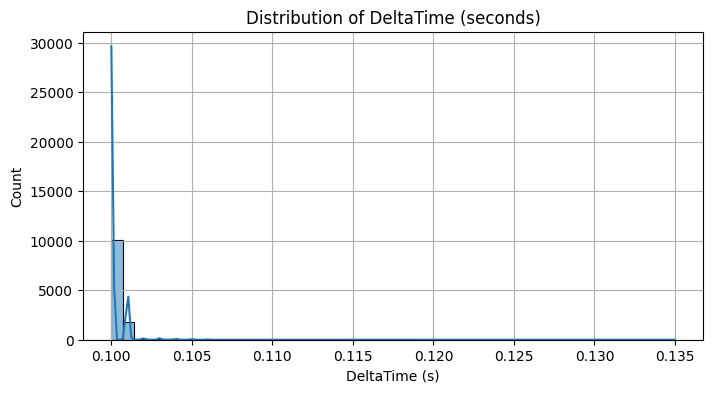

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(df_storage['DeltaTime'], bins=50, kde=True)
plt.title('Distribution of DeltaTime (seconds)')
plt.xlabel('DeltaTime (s)')
plt.ylabel('Count')
plt.grid()
plt.show()

In most cases, DeltaTime ≈ 0.100s, meaning that data is recorded at a frequency of every 100 ms.
<br>
Values above approximately 0.102s may indicate system delays, communication issues, or interruptions in operation — they should be flagged as outliers or timing anomalies.

Conclusion: You can create a flag:
isTimingAnomaly = DeltaTime > 0.102

4.3. Histogram of `ActiveSignals` distibution

Text(0.5, 1.0, 'Number of Active Signals per Record')

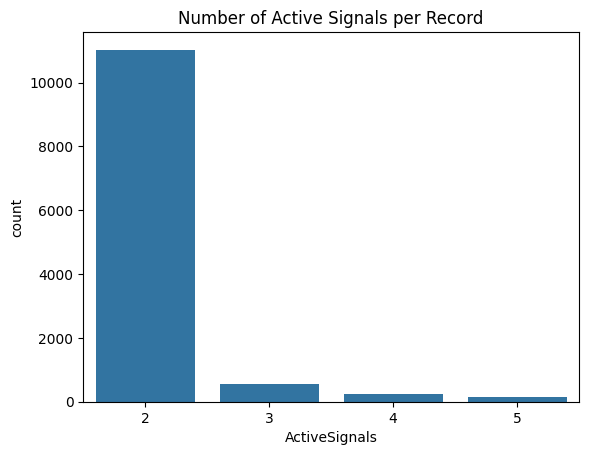

In [10]:
sns.countplot(x='ActiveSignals', data=df_storage)
plt.title('Number of Active Signals per Record')

The most common value is 2, which suggests that at any given moment, at least two signals are always active in parallel.
<br>
The absence of value 1 may indicate that the system does not operate in isolated states — there is always a pair of active signals.
<br>
Values of 3, 4, or 5 may point to unnaturally high parallel activity, potentially indicating a problem scenario such as a bottleneck, excessive pressure, or a valve malfunction.

Conclusion: You can treat ActiveSignals > 2 as a pattern to investigate potential blockages or sequence errors.

4.4. Active signals vs Time

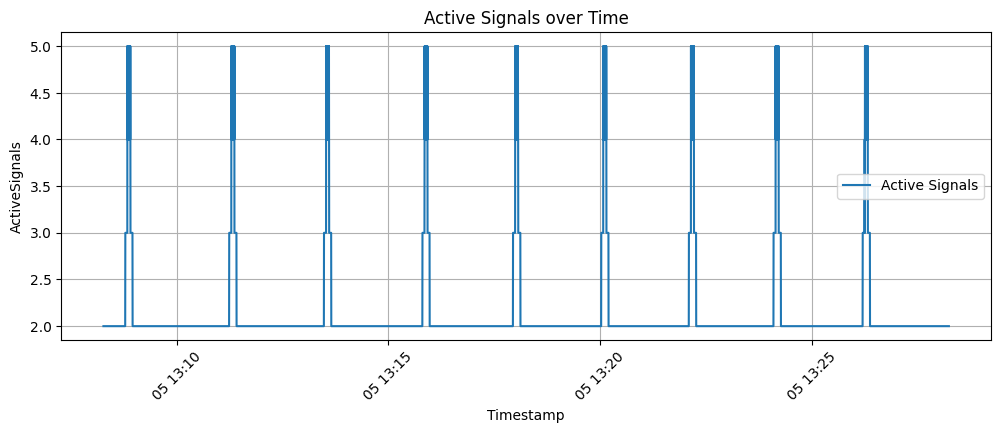

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(df_storage['Timestamp'], df_storage['ActiveSignals'], label='Active Signals')
plt.title('Active Signals over Time')
plt.xlabel('Timestamp')
plt.ylabel('ActiveSignals')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

The chart shows spikes reaching a value of 5 — these are moments when multiple signals were active simultaneously.
<br>
Between these spikes, the signal returns to a level of 2 (possibly indicating normal operation).
<br>
The step-like pattern may suggest precisely synchronized cycles, meaning the device operates within predefined time windows.

Conclusion: It’s worth flagging these spikes as potential “cycle moments” and comparing them with periods of Idle.

4.5. IsIdle in spred of time

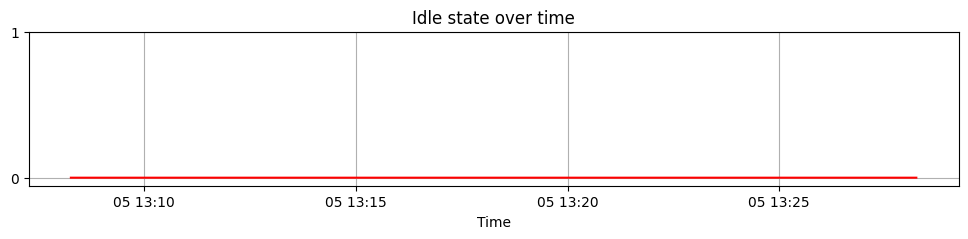

In [12]:
plt.figure(figsize=(12, 2))
plt.plot(df_storage['Timestamp'], df_storage['IsIdle'], color='red', label='IsIdle')
plt.title('Idle state over time')
plt.xlabel('Time')
plt.yticks([0, 1])
plt.grid()
plt.show()

According to the assumption, IsIdle = 1 occurs only when ActiveSignals == 0.
<br>
Here, we observe only a few short idle periods — meaning the machine is operating almost continuously.

Conclusion: The absence of downtime is a positive sign, but it's worth examining those few moments where Idle = 1 — they might indicate something (e.g., transitions between cycles?).

4.6. Heatmapa

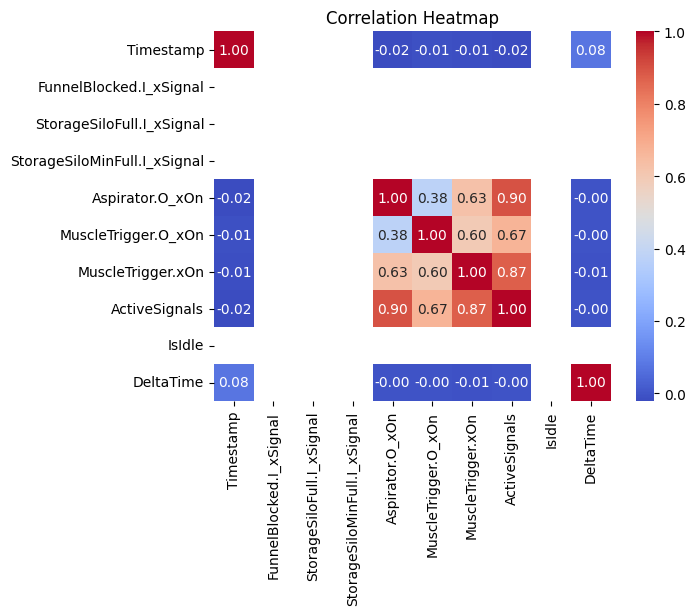

In [13]:
sns.heatmap(df_storage.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There is a strong correlation between MuscleTrigger.O_xOn, MuscleTrigger.xOn, and Aspirator.O_xOn.
<br>
This may indicate cyclical operation of a unit: aspirator + actuator — e.g., the aspirator activates, then the actuator triggers, followed by a reset.
<br>
A correlation of approximately 0.9 indicates a very strong relationship, meaning the signals often activate together.

Conclusion: These relationships can be used as features in a machine learning model (e.g., triggered_together = 1) or for logical detection of inconsistent sequences.

#### 5. Checking outliers values 

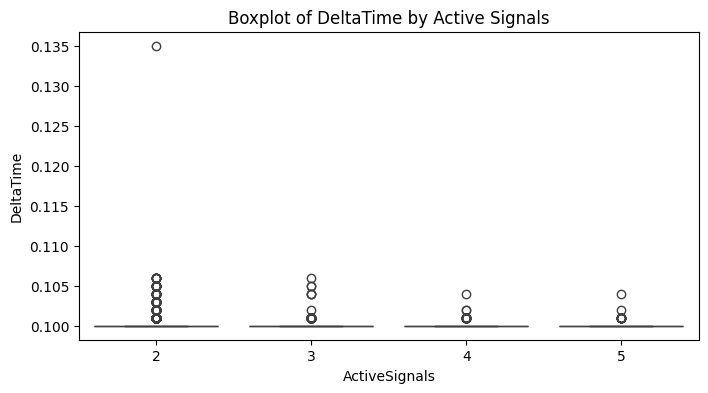

In [14]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='ActiveSignals', y='DeltaTime', data=df_storage)
plt.title('Boxplot of DeltaTime by Active Signals')
plt.show()

In [15]:
Q1 = df_storage['DeltaTime'].quantile(0.25)
Q3 = df_storage['DeltaTime'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_storage[(df_storage['DeltaTime'] < (Q1 - 1.5 * IQR)) | (df_storage['DeltaTime'] > (Q3 + 1.5 * IQR))]

print(f"Number of outliers in DeltaTime: {len(outliers)}")

Number of outliers in DeltaTime: 1919


Based on the IQR method, a new column `IsTimingOutlier` has been added.  
This binary flag indicates whether a record's `DeltaTime` is statistically considered an outlier.  
These values are not removed from the dataset — instead, they are kept and passed as features to the ML model.

* 0 -> normal value 
* 1 -> Outlier

In [16]:
df_storage['IsTimingOutlier'] = df_storage.index.isin(outliers.index).astype(int)

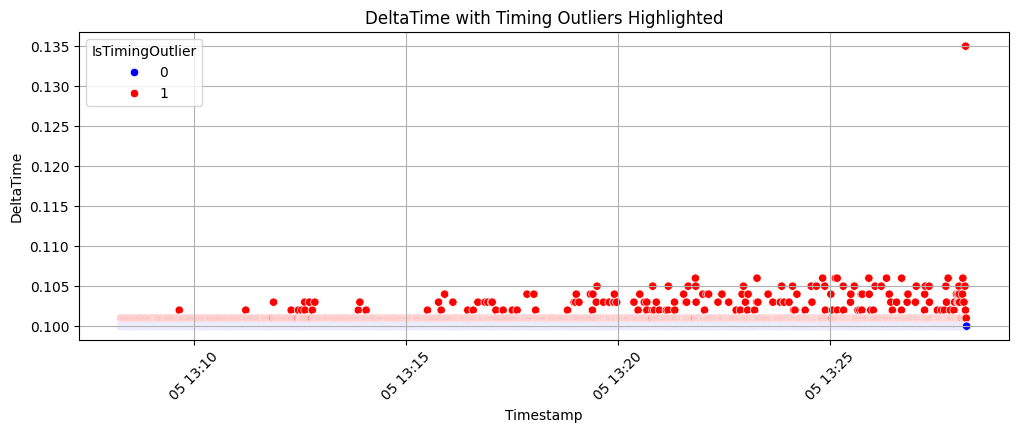

In [17]:
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x='Timestamp',
    y='DeltaTime',
    hue='IsTimingOutlier',
    palette={0: 'blue', 1: 'red'},
    data=df_storage
)
plt.title('DeltaTime with Timing Outliers Highlighted')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='IsTimingOutlier')
plt.show()

In [18]:
df_storage['Minute'] = df_storage['Timestamp'].dt.floor('T')
outliers_by_minute = df_storage.groupby('Minute')['IsTimingOutlier'].mean().reset_index()

C:\Users\marci\AppData\Local\Temp\ipykernel_36088\1289392186.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_storage['Minute'] = df_storage['Timestamp'].dt.floor('T')


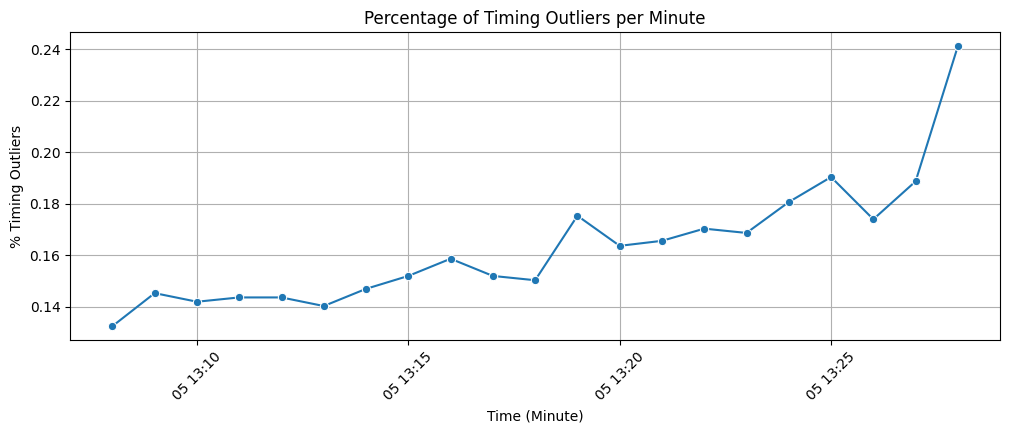

In [19]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=outliers_by_minute, x='Minute', y='IsTimingOutlier', marker='o')
plt.title('Percentage of Timing Outliers per Minute')
plt.xlabel('Time (Minute)')
plt.ylabel('% Timing Outliers')
plt.xticks(rotation=45)
plt.grid()
plt.show()

The percentage of timing anomalies gradually increases throughout the observation window.
This may indicate system degradation, growing instability, or external interference affecting the signal timing

#### 5. Preparation of futures for model - create matrix (Isolation forest)

In [20]:
df_storage.head()

,Timestamp,FunnelBlocked.I_xSignal,StorageSiloFull.I_xSignal,StorageSiloMinFull.I_xSignal,Aspirator.O_xOn,MuscleTrigger.O_xOn,MuscleTrigger.xOn,ActiveSignals,IsIdle,DeltaTime,IsTimingOutlier,Minute
0,2018-01-05 13:08:16.228,0,1,1,0,0,0,2,0,NaN,0,2018-01-05 13:08:00
1,2018-01-05 13:08:16.329,0,1,1,0,0,0,2,0,0.101,1,2018-01-05 13:08:00
2,2018-01-05 13:08:16.429,0,1,1,0,0,0,2,0,0.100,0,2018-01-05 13:08:00
3,2018-01-05 13:08:16.529,0,1,1,0,0,0,2,0,0.100,0,2018-01-05 13:08:00
4,2018-01-05 13:08:16.629,0,1,1,0,0,0,2,0,0.100,0,2018-01-05 13:08:00


In [21]:
df_storage['DeltaTime'] = df_storage['DeltaTime'].fillna(0)  # Fill NaN values with 0

Chose features to model 

In [22]:
features = [
    'ActiveSignals',
    'DeltaTime',
    'IsIdle',
    'IsTimingOutlier',
    'Aspirator.O_xOn',
    'MuscleTrigger.O_xOn',
    'MuscleTrigger.xOn'
]

X = df_storage[features].copy()
X = X.fillna(0)

Traning model

In [23]:
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X)

IsolationForest(contamination=0.05, random_state=42)

Anomaly prediction

In [24]:
df_storage['Anomaly'] = model.predict(X)
df_storage['Anomaly'] = df_storage['Anomaly'].map({1: 0, -1: 1})

In [25]:
print(df_storage['Anomaly'].value_counts())

Anomaly
0    11380
1      577
Name: count, dtype: int64


In [26]:
anomalies_by_minute = df_storage.groupby('Minute')['Anomaly'].mean().reset_index()
anomalies_by_minute

,Minute,Anomaly
0,2018-01-05 13:08:00,0.114155
1,2018-01-05 13:09:00,0.000000
2,2018-01-05 13:10:00,0.000000
3,2018-01-05 13:11:00,0.086811
4,2018-01-05 13:12:00,0.005008
5,2018-01-05 13:13:00,0.085142
6,2018-01-05 13:14:00,0.000000
7,2018-01-05 13:15:00,0.086811
8,2018-01-05 13:16:00,0.006678
9,2018-01-05 13:17:00,0.020033


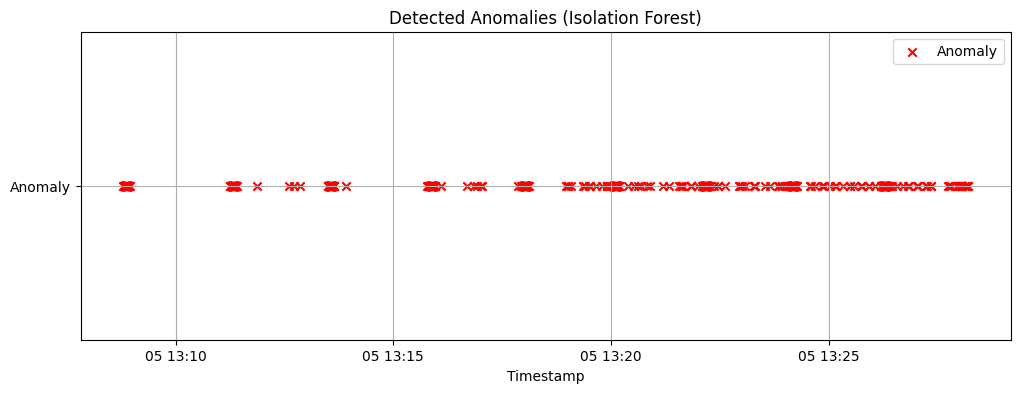

In [27]:
plt.figure(figsize=(12, 4))
anomalies = df_storage[df_storage['Anomaly'] == 1]

plt.scatter(anomalies['Timestamp'], [1]*len(anomalies), color='red', label='Anomaly', marker='x')
plt.title('Detected Anomalies (Isolation Forest)')
plt.xlabel('Timestamp')
plt.yticks([1], ['Anomaly'])
plt.grid()
plt.legend()
plt.show()

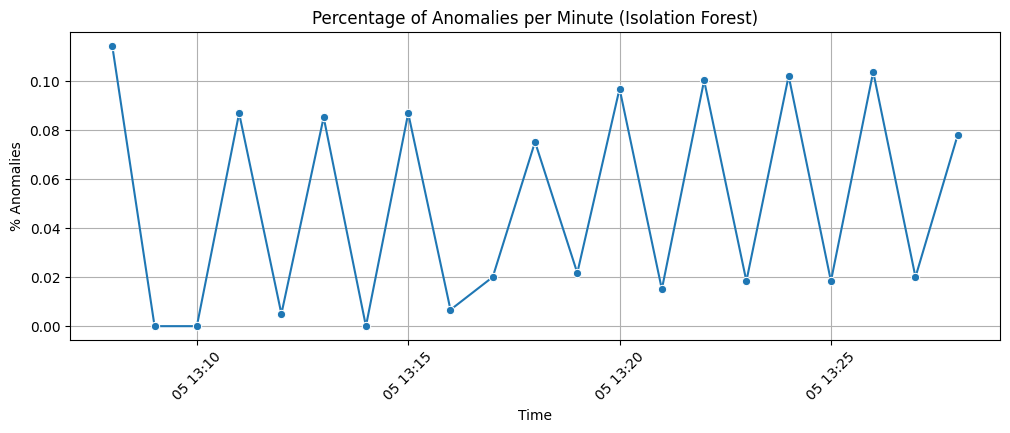

In [28]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=anomalies_by_minute, x='Minute', y='Anomaly', marker='o')
plt.title('Percentage of Anomalies per Minute (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('% Anomalies')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Applied Isolation Forest to detect anomalies in time-series manufacturing sensor data.
Features such as timing gaps (DeltaTime), activity indicators, and system triggers were engineered and used to train the model.
Anomaly density increased over time, indicating potential process degradation.
Results were aggregated and visualized as anomaly percentages per minute — forming the basis for real-time KPIs.

In [29]:
joblib.dump(model, '../03_ExportResults_notebooks/isolation_forest_model.pkl')


['../03_ExportResults_notebooks/isolation_forest_model.pkl']